In [99]:
%pip install seaborn


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [100]:
import pandas as pd
import numpy as np
import torch as pt

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [101]:
from pathlib import Path

list(Path("../../acts/Llama3/8B/chat/").iterdir())

[PosixPath('../../acts/Llama3/8B/chat/sp_en_trans_disj'),
 PosixPath('../../acts/Llama3/8B/chat/sp_en_trans_de'),
 PosixPath('../../acts/Llama3/8B/chat/sp_en_trans_conj'),
 PosixPath('../../acts/Llama3/8B/chat/sp_en_trans'),
 PosixPath('../../acts/Llama3/8B/chat/smaller_than'),
 PosixPath('../../acts/Llama3/8B/chat/real_world_scenarios'),
 PosixPath('../../acts/Llama3/8B/chat/neg_sp_en_trans_de'),
 PosixPath('../../acts/Llama3/8B/chat/neg_sp_en_trans'),
 PosixPath('../../acts/Llama3/8B/chat/neg_inventors_de'),
 PosixPath('../../acts/Llama3/8B/chat/neg_inventors'),
 PosixPath('../../acts/Llama3/8B/chat/neg_facts_de'),
 PosixPath('../../acts/Llama3/8B/chat/neg_facts'),
 PosixPath('../../acts/Llama3/8B/chat/neg_element_symb_de'),
 PosixPath('../../acts/Llama3/8B/chat/neg_element_symb'),
 PosixPath('../../acts/Llama3/8B/chat/neg_cities_de'),
 PosixPath('../../acts/Llama3/8B/chat/neg_cities'),
 PosixPath('../../acts/Llama3/8B/chat/neg_animal_class_de'),
 PosixPath('../../acts/Llama3/8B/chat

In [102]:
# paths = list(Path("../../acts/Llama3/8B/chat/").iterdir())
paths = [Path(p_str) for p_str in ("../../acts/Llama3/8B/chat/cities", "../../acts/Llama3/8B/chat/inventors", "../../acts/Llama3/8B/chat/element_symb")]

In [103]:
tensors = []
datasets = []
for i, dset_dir in enumerate(paths):
    dset_name = dset_dir.name
    try:
        datasets.append(pd.read_csv(f"../../datasets/{dset_name}.csv"))
    except Exception as e:
        print(f"../../datasets/{dset_name}.csv")
        continue
    
    for file in sorted(dset_dir.iterdir(), key=lambda file_: int(str(file_).split("_")[-1].split(".")[0])):
        if "layer_12" not in str(file):
            continue
        tensors.append(pt.load(file))
        
    if i < 10 or i > 15:
        continue


In [104]:
activations = pt.cat(tensors, axis=0).to("cpu")

In [105]:
(activations.element_size() * activations.nelement()) / 1e6 # mb

34.209792

In [108]:
dummy_data = pd.concat([d["label"] for d in datasets], axis=0).reset_index(drop=True).to_frame()
dummy_data

,label
0,1
1,0
2,1
3,0
4,1
...,...
2083,1
2084,0
2085,1
2086,1


In [109]:
# dummy_data = pd.read_csv("../../datasets/animal_class.csv")
dummy_data["correct"] = dummy_data["label"].astype(bool)

In [110]:
dataset_size = activations.shape[0]
dataset_size

2088

In [111]:
# dataset_size = 1000
# wrong_predictions_count = 500

# choices = ['A', 'B', 'C', 'D']
# dummy_data = pd.DataFrame({"prediction": np.random.choice(choices, dataset_size)})
# dummy_data["target"] = dummy_data["prediction"].copy()
# dummy_data.iloc[-wrong_predictions_count:].loc[:, "target"] = "F"
# dummy_data = dummy_data.reset_index()
# dummy_data["correct"] = dummy_data["prediction"] == dummy_data["target"]
# dummy_data

In [113]:
activation_dims = activations.shape[-1]
activation_dims

4096

In [13]:
# correct_vector = np.random.normal(100, 10, activation_dims)
# incorrect_vector = np.random.normal(100, 10, activation_dims)

In [14]:
# activation_list = []
# for c in dummy_data["correct"]:
#     if c:
#         v = correct_vector + np.random.normal(0, 1, activation_dims)
#     else:
#         v = incorrect_vector + np.random.normal(0, 1, activation_dims)
#     activation_list.append(v)
# activations = pt.from_numpy(np.stack(activation_list))
# activations

In [114]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(activations)

pca = PCA(n_components=2)
pca_activations = pca.fit_transform(X_scaled)

<Axes: >

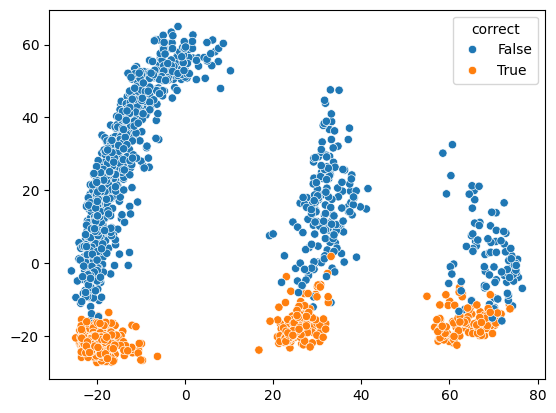

In [115]:
sns.scatterplot(x=pca_activations[:, 0], y=pca_activations[:, 1], hue=dummy_data["correct"])

In [116]:
mu = activations.mean(axis=0)

s = pt.ones(dataset_size)
s[~dummy_data["correct"]] = -1

correctness_direction = pt.mean((activations - mu) * s[:, None], dim=0)
correctness_direction

tensor([-0.0157,  0.0099, -0.0052,  ...,  0.0018, -0.0028,  0.0176])

In [117]:
correctness_end_pca = pca.transform(scaler.transform(correctness_direction[None, :])).squeeze()
correctness_end_pca

array([ 31.98280773, -28.82989443])

In [118]:
zero_pca = pca.transform(scaler.transform([[0]*4096])).squeeze()
correctness_direction_pca = correctness_end_pca - zero_pca

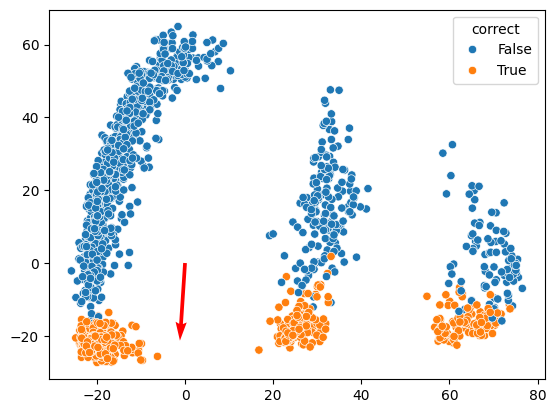

In [119]:
ax = sns.scatterplot(x=pca_activations[:, 0], y=pca_activations[:, 1], hue=dummy_data["correct"])
ax.quiver(0, 0, correctness_direction_pca[0], correctness_direction_pca[1], 
          angles='xy', scale_units='xy', scale=1,
          color='red', label='Vector')

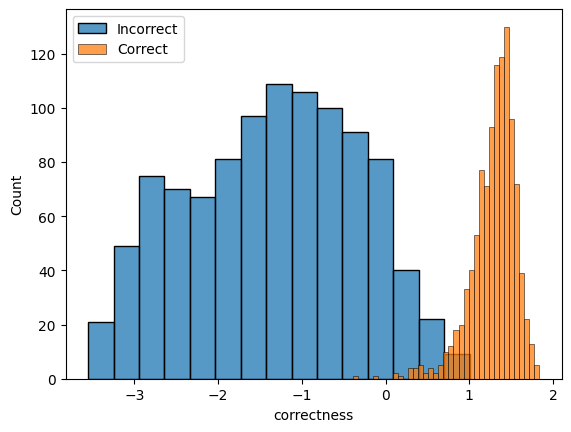

In [120]:
dummy_data["correctness"] = ((activations - mu) @ correctness_direction)
ax = sns.histplot(dummy_data[~dummy_data["correct"]]["correctness"], label="Incorrect")
ax = sns.histplot(dummy_data[dummy_data["correct"]]["correctness"], label="Correct", ax=ax)
ax.legend()

In [121]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(dummy_data["correct"], dummy_data["correctness"])
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.6234581

In [122]:
roc_auc = auc(fpr, tpr)
roc_auc

0.9986137377669243

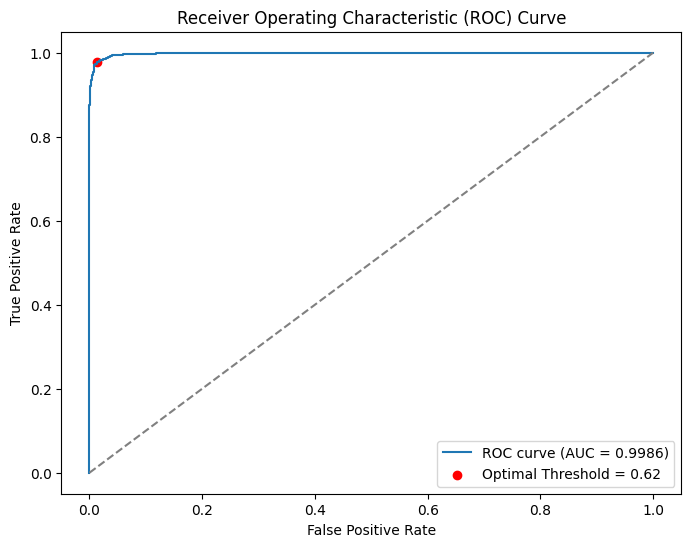

In [123]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [124]:
train_indices = np.random.uniform(0, 1, dataset_size) < 0.8
test_indices = ~train_indices

train_dummy_data = dummy_data.iloc[train_indices]
test_dummy_data = dummy_data.iloc[test_indices]

In [125]:
import torch.nn as nn
import torch.optim as optim

class SingleLayerPerceptron(nn.Module):
    def __init__(self, input_size, output_size):
        super(SingleLayerPerceptron, self).__init__()
        self.fc = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        return self.fc2(nn.functional.relu(self.fc(x)))

model = SingleLayerPerceptron(activation_dims, 1)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(activations[train_indices])
    
    # Convert targets to float tensor
    targets = pt.tensor(train_dummy_data["correct"].to_numpy(), dtype=pt.float32)
    
    # Ensure outputs match target shape
    outputs = outputs.squeeze()
    
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/100], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.6889
Epoch [11/100], Loss: 0.6834
Epoch [21/100], Loss: 0.6779
Epoch [31/100], Loss: 0.6724
Epoch [41/100], Loss: 0.6671
Epoch [51/100], Loss: 0.6617
Epoch [61/100], Loss: 0.6560
Epoch [71/100], Loss: 0.6500
Epoch [81/100], Loss: 0.6433
Epoch [91/100], Loss: 0.6360


In [126]:
test_dummy_data["mlp_classifier_pred"] = nn.functional.sigmoid(model(activations[test_indices])).detach().numpy().squeeze()
test_dummy_data

/tmp/ipykernel_39207/2426868929.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dummy_data["mlp_classifier_pred"] = nn.functional.sigmoid(model(activations[test_indices])).detach().numpy().squeeze()


,label,correct,correctness,mlp_classifier_pred
0,1,True,1.281925,0.539646
9,0,False,0.189503,0.512714
11,0,False,-2.608440,0.437270
13,0,False,-3.552162,0.417205
20,1,True,1.434275,0.542391
...,...,...,...,...
2069,0,False,-1.779910,0.465887
2071,1,True,1.041498,0.531495
2078,0,False,-1.539655,0.474865
2082,0,False,-1.193929,0.475841


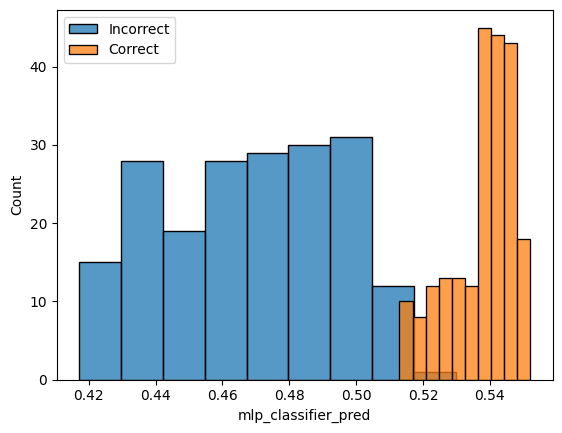

In [127]:
ax = sns.histplot(test_dummy_data[~test_dummy_data["correct"]]["mlp_classifier_pred"], label="Incorrect")
ax = sns.histplot(test_dummy_data[test_dummy_data["correct"]]["mlp_classifier_pred"], label="Correct", ax=ax)
ax.legend()

In [128]:
fpr, tpr, thresholds = roc_curve(test_dummy_data["correct"], test_dummy_data["mlp_classifier_pred"])
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.5129681

In [129]:
roc_auc = auc(fpr, tpr)
roc_auc

0.9984551029139136

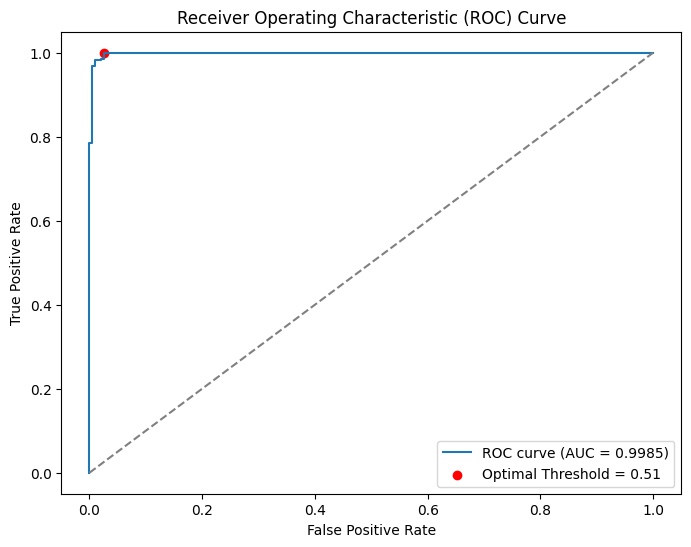

In [130]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()